# [Exp-08]NaverMovieSentiment


## 라이브러리 불러오기


In [1]:
import numpy as np
import pandas as pd
import konlpy
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)


1.4.3
0.6.0
4.2.0


### Tensorflow GPU 확인


In [2]:
# import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.config.list_physical_devices('GPU'))
device_lib.list_local_devices()


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-08-19 23:46:44.382545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 23:46:44.850798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8127163952251673965
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6992625664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16718210357956006502
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

## 데이터 불러오기


[Naver sentiment movie corpus](https://github.com/e9t/nsmc)

- id : 네이버 아이디
- document : 실제 리뷰 내용
- label : 감성(0: 부정, 1: 긍정)


In [3]:
train_data = pd.read_table('data/ratings_train.txt')
test_data = pd.read_table('data/ratings_test.txt')

display(train_data.head())
display(test_data.head())


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [4]:
print(train_data.shape)
print(len(train_data.label.unique()))
print(train_data.duplicated().sum())
train_data.info()


(150000, 3)
2
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


- train 데이터는 15만개, 3개의 열을 가지고 있습니다.
- label의 uniuqe가 2개니 0,1 값만 가지고 있는게 맞습니다.
- document에서 null value를 가지고 있습니다.
- dtype은 document는 object이며(아마 string 같습니다.) 나머진 int 값입니다.


In [5]:
print(test_data.shape)
print(len(test_data.label.unique()))
print(test_data.duplicated().sum())
test_data.info()


(50000, 3)
2
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


- test 데이터도 5만개, 3개의 열을 가지고 있습니다.
- 나머지 특징은 train과 같습니다.


## 데이터 로더 구성


- [Mecab 사용법](https://konlpy-ko.readthedocs.io/ko/v0.4.3/api/konlpy.tag/)


In [6]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘',
             '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


def load_data(train_data, test_data, num_words=10000):
    print("First len(train) :", len(train_data),
          " len(test) :", len(test_data))
    # 중복 값 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')
    print("After delete dulplicate len(train) :", len(
        train_data), " len(test) :", len(test_data))

    # Mecab의 morphs가 string 단위로 읽어오기 때문에
    # 문장으로 받은 뒤 단어를 보면서 불용어인 경우에는 넣지 않습니다.
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    print('len(X_train) :', len(X_train), ' len(X_test) :', len(X_test))

    # 문장들을 연결한뒤 리스트로 바꿔줍니다.
    words = np.concatenate(X_train).tolist()
    # 리스트의 요소와 개수를
    counter = Counter(words)
    # 가장 많이 나온 것들 중들에서 (사용할 단어 - 4)개 만큼 가져온다.
    counter = counter.most_common(num_words - 4)
    # 단어 리스트를 만듭니다.
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + \
        [key for key, _ in counter]
    # 단어:index로 이루어진 딕셔너리를 만듭니다.
    word_to_index = {word: index for index, word in enumerate(vocab)}

    # wordlist를 indexlist로 바꾸는 함수입니다.(단어사전에 없으면 2(<UNK> 인덱스)를 넣습니다.)
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


In [7]:
X_train, y_train, X_test, y_test, word_to_index = load_data(
    train_data, test_data)


First len(train) : 150000  len(test) : 50000
After delete dulplicate len(train) : 146182  len(test) : 49157
len(X_train) : 146182  len(X_test) : 49157


In [8]:
index_to_word = {index: word for word, index in word_to_index.items()}


In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.


def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.


def get_decoded_sentence(encoded_sentence, index_to_word):
    # [1:]를 통해 <BOS>를 제외
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.


def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


## 모델 구성을 위한 데이터 분석 및 가공


### 통계적 확인


In [10]:
print(type(X_train), type(X_test))
print(len(X_train), len(X_test))
print(X_train[0])
print(X_test[0])
print(type(y_train), type(y_test))
print(len(y_train), len(y_test))
print(y_train[0])
print(y_test[0])


<class 'list'> <class 'list'>
146182 49157
[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
[832, 130]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
146182 49157
0
1


In [11]:
word_to_index


{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

In [12]:
index_to_word


{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

- word_to_index : 단어 - 숫자로 이루어진 사전
- index_to_word : 숫자 - 단어로 이루어진 사전
- X_train, X_test 로 단어 사전을 만듭니다.


### 데이터셋 내 문장 길이 분포


num_tokens : [10 17  3 ... 15 23  4]
문장길이 평균 : 15.969376315021577
문장길이 중간값 : 12.0
문장길이 최대 : 116
문장길이 표준편차:  12.843535456326455
문장길이 최빈값:  7


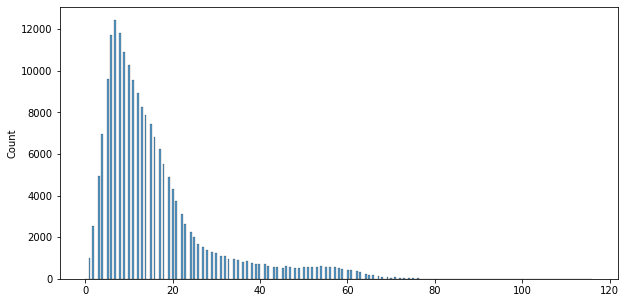

In [13]:
total_train_data = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_train_data]
num_tokens = np.array(num_tokens)
num_tokens_count = np.bincount(num_tokens)

print('num_tokens :', num_tokens)
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 중간값 :', np.median(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))
print('문장길이 최빈값: ', num_tokens_count.argmax())

plt.figure(figsize=(10, 5))
sns.histplot(num_tokens)
plt.show()


### 적절한 최대 문장 길이 지정


In [14]:
num_tokens_count


array([    5,  1015,  2554,  4951,  6936,  9580, 11741, 12441, 11822,
       10907, 10287,  9531,  8929,  8253,  7867,  7440,  6823,  6258,
        5535,  4869,  4312,  3746,  3136,  2653,  2242,  1993,  1688,
        1512,  1376,  1270,  1242,  1107,  1074,   947,   951,   927,
         814,   854,   763,   714,   728,   712,   623,   583,   580,
         537,   594,   575,   528,   499,   547,   560,   573,   587,
         597,   583,   569,   567,   539,   455,   438,   409,   358,
         306,   254,   193,   172,   131,    97,    88,    58,    63,
          39,    26,    15,    26,    22,     8,     8,     7,     4,
           2,     2,     1,     1,     1,     2,     0,     2,     0,
           0,     0,     0,     1,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     1,     1,     0,
           0,     0,     0,     0,     0,     0,     0,     1,     1])

분포를 보고 문장 개수의 빈도수 가 1000개 이하인 길이부터는 사용하지 않겠습니다.


In [15]:
for i, count in enumerate(num_tokens_count):
    if i != 0:
        if count < 1000:
            print(i)
            break


33


33 부터 천개가 안되니 32까지 쓰겠습니다.


In [16]:
max_len = 32


### 패딩 추가


pre 방식으로 <'PAD'> 에 해당하는 인덱스를 넣어줍시다.


In [17]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, value=word_to_index['<PAD>'], padding='pre', maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(
    X_test, value=word_to_index['<PAD>'], padding='pre', maxlen=max_len)


In [18]:
X_train


array([[   0,    0,    0, ...,   20,   33,  748],
       [   0,    0,    0, ...,   15,   44,  391],
       [   0,    0,    0, ...,   24,  205,    2],
       ...,
       [   0,    0,    0, ..., 2710,    6,   18],
       [   0,    0,    0, ...,   60,  395, 8573],
       [   0,    0,    0, ...,   88, 2740,    5]], dtype=int32)

In [19]:
X_test


array([[   0,    0,    0, ...,    0,  832,  130],
       [   0,    0,    0, ...,    0,    0,    2],
       [   0,    0,    0, ..., 3557,   73,  917],
       ...,
       [   0,    0,    0, ...,    8,   12, 3424],
       [   0,    0,    0, ...,   67,  323,   43],
       [   0,    0,    0, ...,  179,   63, 1058]], dtype=int32)

## 모델 구성 및 validation set 구성


### 단어 사전 및 워드 벡터 크기 설정


In [20]:
vocab_size = len(word_to_index)
vocab_size
word_vector_dim = 4


### LSTM


In [21]:
def LSTM(vocab_size=vocab_size, word_vector_dim=word_vector_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.LSTM(8))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model


LSTM().summary()


2022-08-19 23:47:04.073961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 4)           40000     
                                                                 
 lstm (LSTM)                 (None, 8)                 416       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


### CNN 1D


In [22]:
def CNN1D(vocab_size=vocab_size, word_vector_dim=word_vector_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model


CNN1D().summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 4)           40000     
                                                                 
 conv1d (Conv1D)             (None, None, 16)          464       
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

### CNN Maxpooling


In [23]:
def CNNMax(vocab_size=vocab_size, word_vector_dim=word_vector_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model


CNNMax(vocab_size, word_vector_dim).summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 4)           40000     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 4)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 40        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


### Validation Set 설정


In [24]:
print(len(X_train), len(y_train))

X_val = X_train[50000:]
y_val = y_train[50000:]

partial_X_train = X_train[50000:]
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)


146182 146182
(96182, 32)
(96182,)


## 모델 훈련


In [25]:
def train_model(model, epochs=20):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=1)

    result = model.evaluate(X_test, y_test, verbose=1)
    print(result)

    history_dict = history.history

    return history_dict


### LSTM


In [26]:
model_LSTM = LSTM()
LSTM_history = train_model(model_LSTM)


Epoch 1/20


2022-08-19 23:47:08.224341: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


188/188 [==============================] - 5s 7ms/step - loss: 0.5883 - accuracy: 0.7122 - val_loss: 0.4388 - val_accuracy: 0.8277
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3880 - accuracy: 0.8400 - val_loss: 0.3432 - val_accuracy: 0.8604
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3394 - accuracy: 0.8589 - val_loss: 0.3160 - val_accuracy: 0.8723
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3219 - accuracy: 0.8671 - val_loss: 0.3030 - val_accuracy: 0.8788
Epoch 5/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3114 - accuracy: 0.8731 - val_loss: 0.2953 - val_accuracy: 0.8815
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3038 - accuracy: 0.8753 - val_loss: 0.2900 - val_accuracy: 0.8847
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2983 - accuracy: 0.8784 - val_loss: 0.2823 - val_accuracy: 0.8879
Epoch 8/20
188/18

### CNN 1D


In [27]:
model_CNN1 = CNN1D()
CNN1_history = train_model(model_CNN1)


Epoch 1/20
188/188 [==============================] - 2s 6ms/step - loss: 0.6240 - accuracy: 0.6593 - val_loss: 0.5149 - val_accuracy: 0.8255
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.4880 - accuracy: 0.8301 - val_loss: 0.4447 - val_accuracy: 0.8558
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.4286 - accuracy: 0.8514 - val_loss: 0.3379 - val_accuracy: 0.8700
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3332 - accuracy: 0.8626 - val_loss: 0.3018 - val_accuracy: 0.8799
Epoch 5/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3111 - accuracy: 0.8718 - val_loss: 0.2867 - val_accuracy: 0.8858
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2975 - accuracy: 0.8781 - val_loss: 0.2763 - val_accuracy: 0.8905
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2842 - accuracy: 0.8841 - val_loss: 0.2639 - val_accuracy: 0.8958
Epoch 

### CNN Maxpooling


In [28]:
model_CNNM = CNNMax()
CNNM_history = train_model(model_CNNM)


Epoch 1/20
188/188 [==============================] - 1s 3ms/step - loss: 0.6532 - accuracy: 0.6904 - val_loss: 0.5769 - val_accuracy: 0.7818
Epoch 2/20
188/188 [==============================] - 0s 3ms/step - loss: 0.4989 - accuracy: 0.7957 - val_loss: 0.4305 - val_accuracy: 0.8181
Epoch 3/20
188/188 [==============================] - 0s 3ms/step - loss: 0.4085 - accuracy: 0.8230 - val_loss: 0.3784 - val_accuracy: 0.8386
Epoch 4/20
188/188 [==============================] - 0s 3ms/step - loss: 0.3734 - accuracy: 0.8387 - val_loss: 0.3533 - val_accuracy: 0.8497
Epoch 5/20
188/188 [==============================] - 0s 3ms/step - loss: 0.3535 - accuracy: 0.8484 - val_loss: 0.3370 - val_accuracy: 0.8573
Epoch 6/20
188/188 [==============================] - 0s 3ms/step - loss: 0.3396 - accuracy: 0.8545 - val_loss: 0.3249 - val_accuracy: 0.8635
Epoch 7/20
188/188 [==============================] - 0s 3ms/step - loss: 0.3293 - accuracy: 0.8597 - val_loss: 0.3159 - val_accuracy: 0.8669
Epoch 

## Loss, Accuracy 그래프 시각화


### 그래프를 그리는 함수를 만듭니다.


In [29]:
def draw_graph(history_dict, epochs=20):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, epochs + 1)

    plt.figure(figsize=(10, 10))
    sns.lineplot(epochs, loss, label='Training loss')
    sns.lineplot(epochs, val_loss, label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(13, 10))
    sns.lineplot(epochs, acc, label='Training acc')
    sns.lineplot(epochs, val_acc, label='Validation acc')

    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


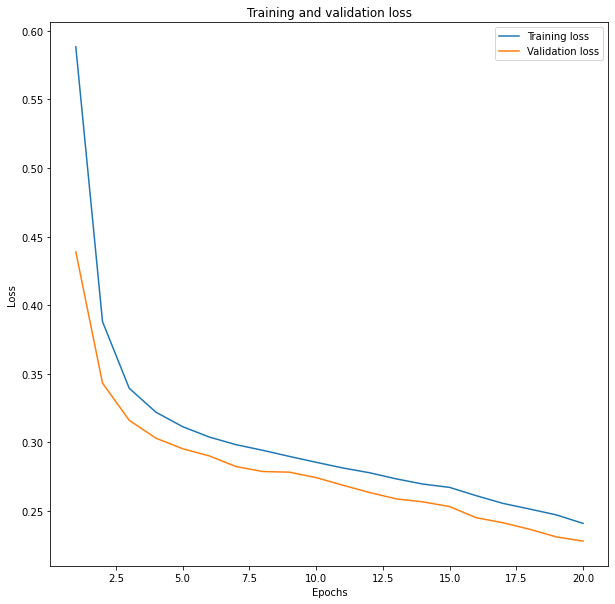

/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


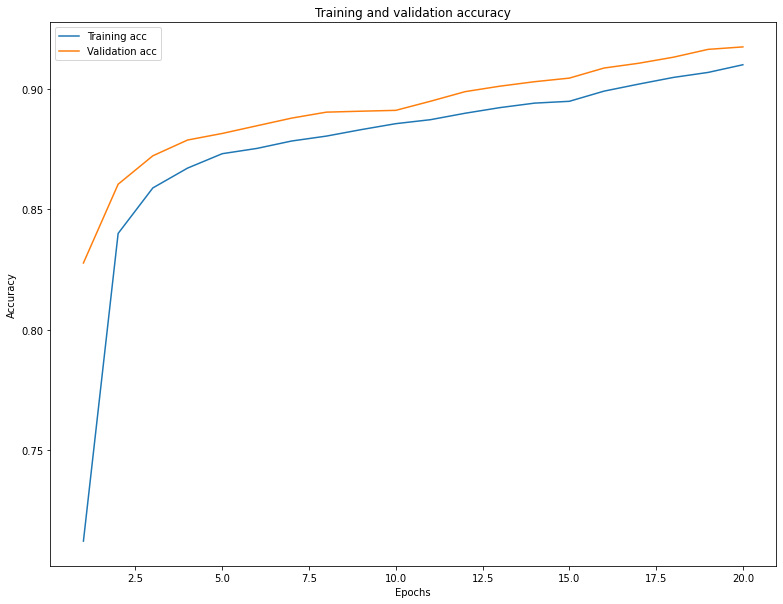

In [30]:
draw_graph(LSTM_history)


/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


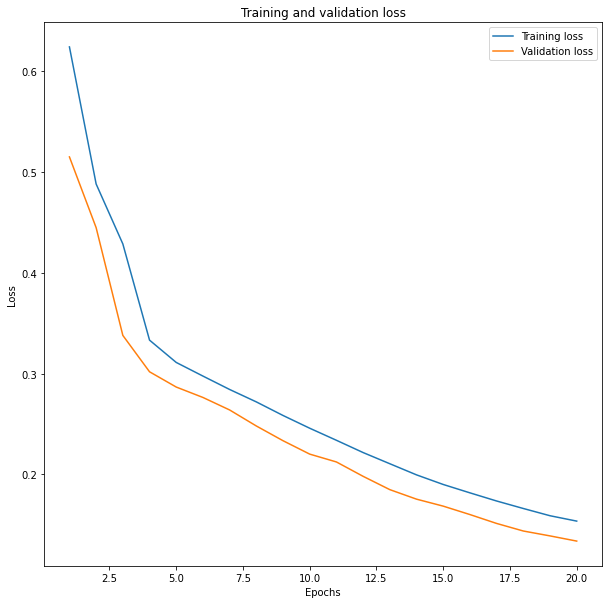

/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


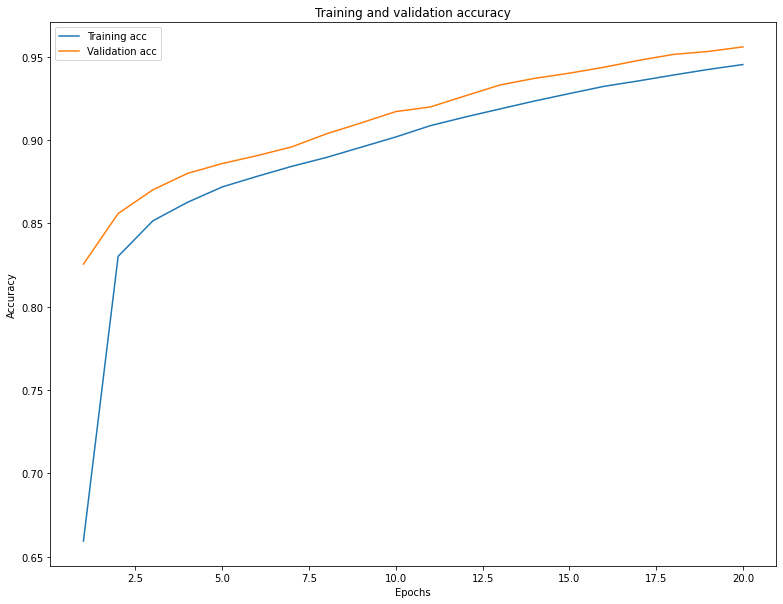

In [31]:
draw_graph(CNN1_history)


/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


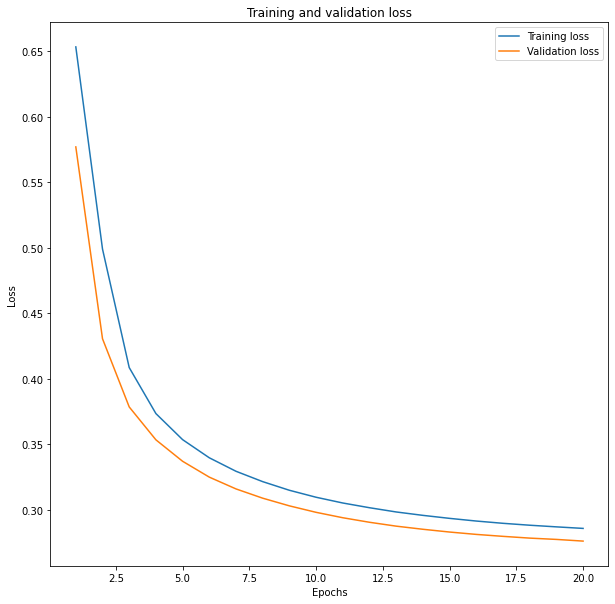

/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


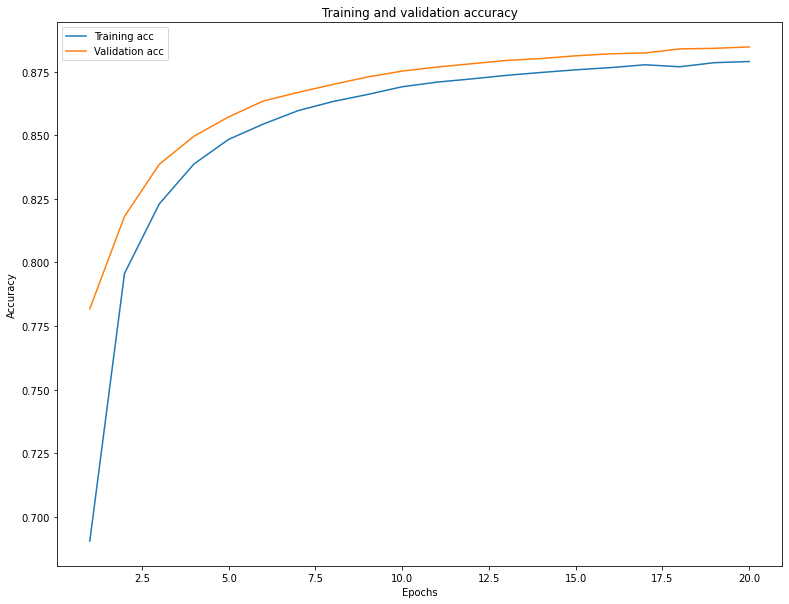

In [32]:
draw_graph(CNNM_history)


## 학습된 Embedding Layer 분석


### 모델에 따라 파일 만드는 함수


In [33]:
def get_Embedding_layer(model, file_path):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    print(weights.shape)

    f = open(file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
    vectors = model.get_weights()[0]
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(
            map(str, list(vectors[i, :])))))
    f.close()


### 파일 생성


In [34]:
LSTM_path = 'data/word2vec_LSTM.txt'
CNN1_path = 'data/word2vec_CNN1.txt'
CNNM_path = 'data/word2vec_CNNM.txt'

get_Embedding_layer(model_LSTM, LSTM_path)
get_Embedding_layer(model_CNN1, CNN1_path)
get_Embedding_layer(model_CNNM, CNNM_path)


(10000, 4)
(10000, 4)
(10000, 4)


In [35]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

LSTM_word_vectors = Word2VecKeyedVectors.load_word2vec_format(
    LSTM_path, binary=False)
CNN1_word_vectors = Word2VecKeyedVectors.load_word2vec_format(
    CNN1_path, binary=False)
CNNM_word_vectors = Word2VecKeyedVectors.load_word2vec_format(
    CNNM_path, binary=False)


## 한국어 Word2Vec 임베딩 활용


In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models.keyedvectors import *
word_vectors = Word2VecKeyedVectors.load('data/word2vec_ko.model')
vector = word_vectors.wv['끝']
vector


array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

### 분석


같은 단어를 가지고 각각의 워드 벡터들을 비교해봅시다.


In [37]:
LSTM_word_vectors.similar_by_word('사랑')


[('이중', 0.9995709657669067),
 ('으로부터', 0.9995263814926147),
 ('찾아본', 0.9995051026344299),
 ('감명깊', 0.9992008209228516),
 ('지나갔', 0.9989590644836426),
 ('재미있', 0.9984164237976074),
 ('와우', 0.9980723857879639),
 ('재능', 0.9979626536369324),
 ('노년', 0.9979438781738281),
 ('느낀', 0.9975847601890564)]

In [38]:
CNN1_word_vectors.similar_by_word('사랑')


[('아픔', 0.999751627445221),
 ('상관', 0.9993441700935364),
 ('바라보', 0.9986539483070374),
 ('지금', 0.9977360367774963),
 ('풀어낼', 0.9976575374603271),
 ('대작', 0.9975223541259766),
 ('피아노', 0.9973872900009155),
 ('나와도', 0.9971949458122253),
 ('편안', 0.9967674612998962),
 ('동시대', 0.9966591596603394)]

In [39]:
CNNM_word_vectors.similar_by_word('사랑')


[('슬픈', 0.9997158646583557),
 ('는데요', 0.9996439218521118),
 ('야호', 0.9994201064109802),
 ('조아', 0.9993518590927124),
 ('이영애', 0.9992538690567017),
 ('울린다', 0.9991244077682495),
 ('입담', 0.9988644123077393),
 ('고민', 0.9988341331481934),
 ('꿈', 0.9987737536430359),
 ('me', 0.9987373948097229)]

In [40]:
word_vectors.wv.similar_by_word('사랑')


[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

- 레이어 분석 :
생각보다 CNN1, CNNM이 LSTM보단 더 연관성 있는 단어들이 많이 나왔고  
확실히 데이터셋의 차이로 인해 명사들이 많이 나왔습니다.  
새로 만든 word_vector은 다른 3가지 보다 연관성도 높고 모두 추상적인 단어들(같은 종류)이 나왔습니다.


### 성능 향상


In [41]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 100


def newModel(vocab_size=vocab_size, word_vector_dim=word_vector_dim, LSTM_para=8, Dense_para=8, epochs=20):

    embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

    for i in range(4, vocab_size):
        if index_to_word[i] in word_vectors.wv:
            embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

    newModel = tf.keras.Sequential()
    newModel.add(tf.keras.layers.Embedding(vocab_size,
                                           word_vector_dim,
                                           embeddings_initializer=Constant(
                                               embedding_matrix),
                                           input_length=max_len,
                                           trainable=True))
    newModel.add(tf.keras.layers.LSTM(LSTM_para))
    newModel.add(tf.keras.layers.Dense(Dense_para, activation='relu'))
    newModel.add(tf.keras.layers.Dense(Dense_para, activation='relu'))
    newModel.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    newModel.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

    history = newModel.fit(partial_X_train,
                           partial_y_train,
                           epochs=epochs,
                           batch_size=512,
                           validation_data=(X_val, y_val),
                           verbose=1)

    result = newModel.evaluate(X_test,  y_test, verbose=0)
    print(result)


In [42]:
newModel(10000, 100, 32, 32, 30)


Epoch 1/30
188/188 [==============================] - 3s 8ms/step - loss: 0.5381 - accuracy: 0.7213 - val_loss: 0.4260 - val_accuracy: 0.8059
Epoch 2/30
188/188 [==============================] - 1s 6ms/step - loss: 0.4001 - accuracy: 0.8188 - val_loss: 0.3674 - val_accuracy: 0.8371
Epoch 3/30
188/188 [==============================] - 1s 6ms/step - loss: 0.3506 - accuracy: 0.8465 - val_loss: 0.3215 - val_accuracy: 0.8617
Epoch 4/30
188/188 [==============================] - 1s 6ms/step - loss: 0.3201 - accuracy: 0.8627 - val_loss: 0.2979 - val_accuracy: 0.8751
Epoch 5/30
188/188 [==============================] - 1s 6ms/step - loss: 0.2982 - accuracy: 0.8738 - val_loss: 0.2727 - val_accuracy: 0.8879
Epoch 6/30
188/188 [==============================] - 1s 6ms/step - loss: 0.2814 - accuracy: 0.8830 - val_loss: 0.2565 - val_accuracy: 0.8966
Epoch 7/30
188/188 [==============================] - 1s 6ms/step - loss: 0.2661 - accuracy: 0.8890 - val_loss: 0.2535 - val_accuracy: 0.8970
Epoch 

In [43]:
newModel(10000, 100, 16, 16, 20)


Epoch 1/20
188/188 [==============================] - 3s 8ms/step - loss: 0.5733 - accuracy: 0.6939 - val_loss: 0.4573 - val_accuracy: 0.7876
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.4249 - accuracy: 0.8078 - val_loss: 0.3800 - val_accuracy: 0.8351
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3715 - accuracy: 0.8378 - val_loss: 0.3427 - val_accuracy: 0.8533
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3390 - accuracy: 0.8543 - val_loss: 0.3165 - val_accuracy: 0.8674
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3164 - accuracy: 0.8670 - val_loss: 0.2944 - val_accuracy: 0.8781
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3019 - accuracy: 0.8732 - val_loss: 0.2816 - val_accuracy: 0.8857
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2847 - accuracy: 0.8827 - val_loss: 0.2733 - val_accuracy: 0.8881
Epoch 

In [44]:
newModel(10000, 100, 16, 16, 5)


Epoch 1/5
188/188 [==============================] - 3s 7ms/step - loss: 0.5817 - accuracy: 0.6851 - val_loss: 0.4602 - val_accuracy: 0.7864
Epoch 2/5
188/188 [==============================] - 1s 5ms/step - loss: 0.4260 - accuracy: 0.8060 - val_loss: 0.3829 - val_accuracy: 0.8313
Epoch 3/5
188/188 [==============================] - 1s 6ms/step - loss: 0.3720 - accuracy: 0.8358 - val_loss: 0.3419 - val_accuracy: 0.8537
Epoch 4/5
188/188 [==============================] - 1s 5ms/step - loss: 0.3412 - accuracy: 0.8537 - val_loss: 0.3176 - val_accuracy: 0.8665
Epoch 5/5
188/188 [==============================] - 1s 5ms/step - loss: 0.3191 - accuracy: 0.8653 - val_loss: 0.2981 - val_accuracy: 0.8782
[0.36864417791366577, 0.8393718004226685]


In [45]:
newModel(10000, 100, 64, 64, 5)


Epoch 1/5
188/188 [==============================] - 3s 9ms/step - loss: 0.5132 - accuracy: 0.7429 - val_loss: 0.4079 - val_accuracy: 0.8155
Epoch 2/5
188/188 [==============================] - 1s 6ms/step - loss: 0.3853 - accuracy: 0.8270 - val_loss: 0.3372 - val_accuracy: 0.8542
Epoch 3/5
188/188 [==============================] - 1s 6ms/step - loss: 0.3330 - accuracy: 0.8548 - val_loss: 0.2973 - val_accuracy: 0.8739
Epoch 4/5
188/188 [==============================] - 1s 6ms/step - loss: 0.3005 - accuracy: 0.8722 - val_loss: 0.2724 - val_accuracy: 0.8863
Epoch 5/5
188/188 [==============================] - 1s 6ms/step - loss: 0.2756 - accuracy: 0.8851 - val_loss: 0.2522 - val_accuracy: 0.9012
[0.3449785113334656, 0.8484041094779968]


In [46]:
newModel(10000, 100, 64, 32, 5)

Epoch 1/5
188/188 [==============================] - 3s 8ms/step - loss: 0.5185 - accuracy: 0.7350 - val_loss: 0.4086 - val_accuracy: 0.8163
Epoch 2/5
188/188 [==============================] - 1s 6ms/step - loss: 0.3886 - accuracy: 0.8256 - val_loss: 0.3440 - val_accuracy: 0.8516
Epoch 3/5
188/188 [==============================] - 1s 7ms/step - loss: 0.3351 - accuracy: 0.8548 - val_loss: 0.3031 - val_accuracy: 0.8728
Epoch 4/5
188/188 [==============================] - 1s 6ms/step - loss: 0.3046 - accuracy: 0.8695 - val_loss: 0.2805 - val_accuracy: 0.8838
Epoch 5/5
188/188 [==============================] - 1s 6ms/step - loss: 0.2809 - accuracy: 0.8823 - val_loss: 0.2513 - val_accuracy: 0.8992
[0.3480377197265625, 0.8478548526763916]


In [47]:
newModel(10000, 100, 64, 64, 7)

Epoch 1/7
188/188 [==============================] - 3s 9ms/step - loss: 0.5078 - accuracy: 0.7441 - val_loss: 0.4053 - val_accuracy: 0.8186
Epoch 2/7
188/188 [==============================] - 1s 6ms/step - loss: 0.3820 - accuracy: 0.8294 - val_loss: 0.3392 - val_accuracy: 0.8531
Epoch 3/7
188/188 [==============================] - 1s 7ms/step - loss: 0.3332 - accuracy: 0.8545 - val_loss: 0.3084 - val_accuracy: 0.8687
Epoch 4/7
188/188 [==============================] - 1s 7ms/step - loss: 0.3025 - accuracy: 0.8708 - val_loss: 0.2717 - val_accuracy: 0.8867
Epoch 5/7
188/188 [==============================] - 1s 7ms/step - loss: 0.2764 - accuracy: 0.8843 - val_loss: 0.2552 - val_accuracy: 0.8952
Epoch 6/7
188/188 [==============================] - 1s 7ms/step - loss: 0.2542 - accuracy: 0.8951 - val_loss: 0.2251 - val_accuracy: 0.9106
Epoch 7/7
188/188 [==============================] - 1s 7ms/step - loss: 0.2367 - accuracy: 0.9044 - val_loss: 0.2000 - val_accuracy: 0.9240
[0.3625291883

## 회고

* 이번 프로젝트에서 어려웠던 점
    - word2vec를 불러와서 사용하는 법
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된점
    - Shape의 개념을 적용
    - CNN 1D의 유연성
  * 아직 모호한 점
    - LSTM 내부 파라미터의 정의 및 역할
* 루브릭 평가를 맞추기 위해 시도한 점
    - 여러가지 지표를 적용하기 위해 함수를 만들어서 적용하였습니다.
    - 각각의 모델에 대한 그래프를 시각화였습니다.